In [260]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

In [261]:
# Set random seed for reproducibility
# manualSeed = 42
# # manualSeed = random.randint(1, 10000) # use if you want new results
# print("Random Seed: ", manualSeed)
# random.seed(manualSeed)
# torch.manual_seed(manualSeed)
# torch.use_deterministic_algorithms(True) # Needed for reproducible results

In [262]:
dataroot = "data"

batch_size = 50

nz = 10

num_epochs = 50

lr = 8e-4

beta1 = 0.9

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 0

In [263]:
class Dataset():
    def __init__(self, root = dataroot):
        self.root = root
        self.dataset = self.build_dataset()
        self.length = self.dataset.shape[1]

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        step = self.dataset[:, idx]
        return step

    def build_dataset(self):
        dataset = np.load(os.path.join(self.root, "round1.npy")).T
        dataset = torch.from_numpy(dataset).float()
        dataset = torch.unsqueeze(dataset, -1)
        return dataset

In [264]:
dataset = Dataset(dataroot)

In [265]:
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=False)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [266]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        n = m.in_features
        y = 1.0/np.sqrt(n)
        # nn.init.normal_(m.weight.data, 0.0, y)
        # nn.init.uniform_(m.weight.data, -y, y)
        nn.init.normal_(m.weight.data, 0.0, 1e-2)

In [267]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # nn.Linear(nz, 128, bias = False),
            # nn.ReLU(True),
            # nn.Linear(128, 256, bias = False),
            # nn.ReLU(True),
            # nn.Linear(256, 128, bias = False),
            # nn.ReLU(True),
            # nn.Linear(128, 1, bias = False),
            # nn.ReLU(True)
            nn.Linear(nz, 28, bias = False),
            # nn.Sigmoid(),
            nn.ReLU(True),
            nn.Linear(28, 1, bias = False),
            nn.ReLU(True)
        )

    def forward(self, input):
        return self.main(input)

In [268]:
# Create the generator
netG = Generator(ngpu).to(device)

if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))
# netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): Linear(in_features=10, out_features=28, bias=False)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=28, out_features=1, bias=False)
    (3): ReLU(inplace=True)
  )
)


In [269]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # nn.Linear(1, 128, bias = False),
            # nn.LeakyReLU(0.2),
            # nn.Linear(128, 64, bias = False),
            # nn.LeakyReLU(0.2),
            # nn.Linear(64, 1, bias = False),
            # nn.Sigmoid()
            nn.Linear(1, 45, bias = False),
            nn.ReLU(True),
            nn.Linear(45, 49, bias = False),
            nn.ReLU(True),
            nn.Linear(49, 43, bias = False),
            nn.Tanh(),
            nn.Linear(43, 19, bias = False),
            nn.Tanh(),
            nn.Linear(19, 36, bias = False),
            nn.Tanh(),
            nn.Linear(36, 36, bias = False),
            nn.ReLU(True),
            nn.Linear(36, 10, bias = False),
            nn.ReLU(True),
            nn.Linear(10, 10, bias = False),
            nn.ReLU(True),
            nn.Linear(10, 13, bias = False),
            nn.ReLU(True),
            nn.Linear(13, 21, bias = False),
            nn.ReLU(True),
            nn.Linear(21, 1, bias = False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [270]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Linear(in_features=1, out_features=45, bias=False)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=45, out_features=49, bias=False)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=49, out_features=43, bias=False)
    (5): Tanh()
    (6): Linear(in_features=43, out_features=19, bias=False)
    (7): Tanh()
    (8): Linear(in_features=19, out_features=36, bias=False)
    (9): Tanh()
    (10): Linear(in_features=36, out_features=36, bias=False)
    (11): ReLU(inplace=True)
    (12): Linear(in_features=36, out_features=10, bias=False)
    (13): ReLU(inplace=True)
    (14): Linear(in_features=10, out_features=10, bias=False)
    (15): ReLU(inplace=True)
    (16): Linear(in_features=10, out_features=13, bias=False)
    (17): ReLU(inplace=True)
    (18): Linear(in_features=13, out_features=21, bias=False)
    (19): ReLU(inplace=True)
    (20): Linear(in_features=21, out_features=1, bias=False)
    (21): Sigmoid()
  )
)


In [271]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(1, nz, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [272]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        
        ############################
        netD.zero_grad()
        
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

        output = netD(real_cpu).view(-1)

        errD_real = criterion(output, label)

        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        noise = torch.randn(b_size, nz, device=device)

        fake = netG(noise)
        label.fill_(fake_label)
        
        output = netD(fake.detach()).view(-1)

        errD_fake = criterion(output, label)

        errD_fake.backward()
        D_G_z1 = output.mean().item()

        errD = errD_real + errD_fake

        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost

        output = netD(fake).view(-1)

        errG = criterion(output, label)

        errG.backward()
        D_G_z2 = output.mean().item()

        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch+1, num_epochs, i+1, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

Starting Training Loop...
[1/50][1/23]	Loss_D: 1.3864	Loss_G: 0.6931	D(x): 0.4999	D(G(z)): 0.5000 / 0.5000
[2/50][1/23]	Loss_D: 1.3717	Loss_G: 0.6920	D(x): 0.5079	D(G(z)): 0.5005 / 0.5006
[3/50][1/23]	Loss_D: 1.2199	Loss_G: 0.6881	D(x): 0.5933	D(G(z)): 0.5024 / 0.5025
[4/50][1/23]	Loss_D: 0.9356	Loss_G: 0.5797	D(x): 0.8997	D(G(z)): 0.5629 / 0.5608
[5/50][1/23]	Loss_D: 0.8274	Loss_G: 0.6223	D(x): 0.9446	D(G(z)): 0.5369 / 0.5368
[6/50][1/23]	Loss_D: 0.9854	Loss_G: 0.5080	D(x): 0.9499	D(G(z)): 0.6046 / 0.6032
[7/50][1/23]	Loss_D: 0.9850	Loss_G: 0.5329	D(x): 0.9118	D(G(z)): 0.5889 / 0.5878
[8/50][1/23]	Loss_D: 0.9141	Loss_G: 0.5525	D(x): 0.9535	D(G(z)): 0.5764 / 0.5776
[9/50][1/23]	Loss_D: 1.1243	Loss_G: 0.4449	D(x): 0.9305	D(G(z)): 0.6506 / 0.6409
[10/50][1/23]	Loss_D: 1.1239	Loss_G: 0.4767	D(x): 0.8735	D(G(z)): 0.6262 / 0.6216
[11/50][1/23]	Loss_D: 1.0182	Loss_G: 0.5306	D(x): 0.8917	D(G(z)): 0.5924 / 0.5896
[12/50][1/23]	Loss_D: 1.0718	Loss_G: 0.5102	D(x): 0.8571	D(G(z)): 0.5989 / 0.6010

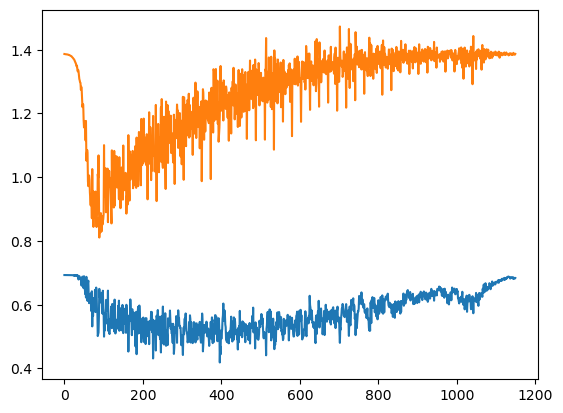

In [273]:
plt.plot(G_losses)
plt.plot(D_losses)

## Génération de données

In [274]:
from DWasserstein4D import dWasserstein4D

In [275]:
data = np.load("data/round1.npy")
N = data.shape[0]

In [276]:
genData = np.empty((N, 4))
for i in range(N):
    noise = torch.randn(b_size, nz, device=device)
    fake = netG(noise)
    genData[i,:] = fake.detach().numpy().T[0]

In [277]:
dWasserstein4D(data, genData, niter = int(1e3))

2.201137546620251

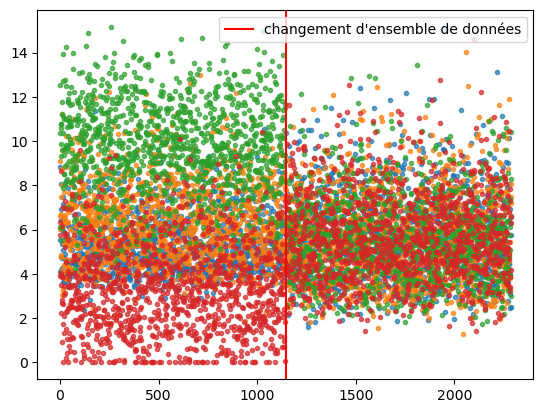

In [278]:
for i in range(4):
    y = np.concatenate((data[:,i], genData[:,i]))
    plt.scatter(list(range(len(y))), y, alpha = 0.7, marker = '.')
plt.axvline(x=1144, color = "red", label = "changement d'ensemble de données")
plt.legend()

In [279]:
# np.save("generated_data/genDataSoline", genData)